In [ ]:
!pip install d2l

In [ ]:
import math
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l

## generating datasets

In [ ]:
max_degree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset sizes
true_w = np.zeros(max_degree)  # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [ ]:
# Convert from NumPy ndarrays to tensors
true_w, features, poly_features, labels = [tf.constant(x, dtype=
    tf.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[-1.4259441 ],
        [ 0.04594775]], dtype=float32)>,
 <tf.Tensor: shape=(2, 20), dtype=float32, numpy=
 array([[ 1.00000000e+00, -1.42594409e+00,  1.01665831e+00,
         -4.83232617e-01,  1.72265664e-01, -4.91282418e-02,
          1.16756875e-02, -2.37841113e-03,  4.23935155e-04,
         -6.71675371e-05,  9.57771499e-06, -1.24157145e-06,
          1.47534280e-07, -1.61827423e-08,  1.64826319e-09,
         -1.56688745e-10,  1.39643366e-11, -1.17131543e-12,
          9.27905756e-14, -6.96390382e-15],
        [ 1.00000000e+00,  4.59477492e-02,  1.05559779e-03,
          1.61674470e-05,  1.85714441e-07,  1.70663217e-09,
          1.30693173e-11,  8.57865279e-14,  4.92712236e-16,
          2.51544632e-18,  1.15579095e-20,  4.82781738e-23,
          1.84856118e-25,  6.53363260e-28,  2.14432645e-30,
          6.56846480e-33,  1.88628846e-35,  5.09827694e-38,
          1.30141391e-40,  3.15292154e-43]], dtype=float32)>,
 <tf.Tensor

## train, test the model

In [ ]:
def evaluate_loss(net, data_iter, loss):  #@save"""Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        l = loss(net(X), y)
        metric.add(tf.reduce_sum(l), d2l.size(l))
    return metric[0] / metric[1]

In [ ]:
# define the training function

def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = tf.losses.MeanSquaredError()
    input_shape = train_features.shape[-1]
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net = tf.keras.Sequential()
    net.add(tf.keras.layers.Dense(1, use_bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    test_iter = d2l.load_array((test_features, test_labels), batch_size,
                               is_train=False)
    trainer = tf.keras.optimizers.SGD(learning_rate=.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net.get_weights()[0].T)

## third-order polynomial funtion fitting (normal)

weight: [[ 5.008064   1.216468  -3.4077816  5.54979  ]]


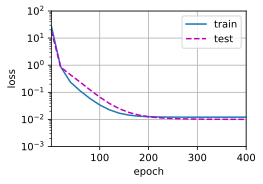

In [ ]:
# Pick the first four dimensions, i.e., 1, x, x^2/2!, x^3/3! from the
# polynomial features
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

## linear function fitting (unferfit)

weight: [[3.049426 4.592027]]


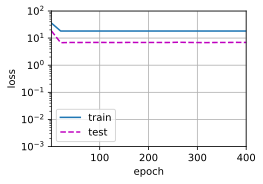

In [ ]:
# Pick the first two dimensions, i.e., 1, x, from the polynomial features
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

## higher-order polynomial duntion fitting (overfit)

weight: [[ 5.0072107   1.2520124  -3.3921545   5.3808856  -0.04824249  0.39706796
   0.24229068  0.42552614 -0.31897593 -0.24351709 -0.1045406   0.25658804
   0.06798165 -0.37161785  0.11201166  0.18090026 -0.02709981 -0.44845748
  -0.27011183  0.05603695]]


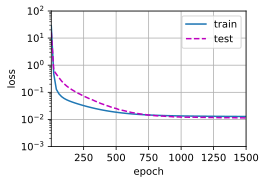

In [ ]:
# Pick all the dimensions from the polynomial features
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)